------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 POS and 1000 NEG **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys POS or
NEG sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [3]:
!python --version

Python 3.8.10


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [4]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [9]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2021-11-03 22:13:10--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.2’

sent_lexicon.2      100%[===================>] 647.05K  --.-KB/s    in 0.02s   

2021-11-03 22:13:10 (41.8 MB/s) - ‘sent_lexicon.2’ saved [662577/662577]

--2021-11-03 22:13:10--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercont

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [10]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., POS and NEG, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (POS, NEG, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [9]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a POS or a
NEG label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more POS than NEG words per review (~7.13 more POS than NEG per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as POS.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{POS} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{NEG} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [12]:
threshold = 8

def get_polarity_lexicon(fp='sent_lexicon'):
  lexicon = {}

  polarity = {'positive': 1, 'negative': -1, 'neutral': 0, 'both': 0}

  with open(fp, mode='r', encoding='utf-8') as f:
    for line in f:
      attrs = line.strip().split(' ')

      attrs = {attr.split('=')[0]:  attr.split('=')[1] for attr in attrs}

      lexicon[attrs['word1']] = attrs
      lexicon[attrs['word1']]['priorpolarity'] = polarity[attrs['priorpolarity']]
      
  return lexicon

sent_lexicon = get_polarity_lexicon()

def classify_binary_score(review):
  score = 0
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      if token.lower() in sent_lexicon:
        score += sent_lexicon[token.lower()]['priorpolarity']
        
  return 'POS' if score - threshold > 0 else 'NEG'

In [13]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = [1 if classify_binary_score(review) == review["sentiment"] else 0 for review in reviews]
token_accuracy = sum(token_results) / len(token_results)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [14]:
def classify_weighted_score(review):
  score = 0
  threshold = 8

  total_weight = 0
  recognized_words = 0

  for sentence in review["content"]:
    for token, pos_tag in sentence:
        if token.lower() in sent_lexicon:
            weight = 2 if sent_lexicon[token.lower()]['type'] == 'strongsubj' else 1
            total_weight += weight
            recognized_words += 1
  
            score += sent_lexicon[token.lower()]['priorpolarity']  * weight

  threshold = threshold * (total_weight / recognized_words)  

  return 'POS' if score - threshold > 0 else 'NEG'

In [15]:
magnitude_results = [1 if classify_weighted_score(review) == review["sentiment"] else 0 for review in reviews]
magnitude_accuracy = sum(magnitude_results) / len(magnitude_results)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.70


#### (Q.1.4) Make a barplot of the two results (0.5pt)

<BarContainer object of 2 artists>

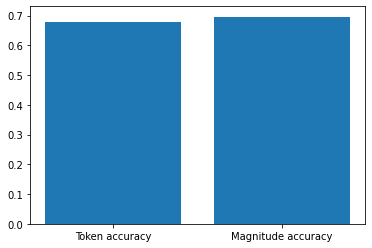

In [16]:
plt.bar(['Token accuracy', 'Magnitude accuracy'], [token_accuracy, magnitude_accuracy])

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more POS than NEG words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

The original threshold value was calculated by averaging over all the documents. This can cause problems when we have very short reviews. Consider a one sentence POS review: Since the threshold biases the classifier towards NEG results, the review may be seen as NEG because it has less than 8 POS words (it is hard to think of one sentence with more than 8 POS words in it!). While the one-sentence review is an edge case, this may be a problem for all reviews which are only a few sentences long, as a majority of the words in a review might be neutral or not display sentiment.

A way to offset this problem would be to calculate the threshold in terms of the review length, compared to the average review length. If ~7.13 is the dataset bias, the bias for a particular review would be $7.13  * review\_length / average\_review\_length$. This only requires the assumption that words with sentiment are uniformly distributed across text of varying length, which, while not perfect, should give a better bias for varying-size reviews. 




In [9]:
avg_review_length = sum(len(sentence) for review in reviews for sentence in review["content"]) / len(reviews)

def get_review_threshold(review):
    return math.ceil(7.13 * sum(len(sentence) for sentence in review["content"]) / avg_review_length) 


def classify_binary_score_var_threshold(review):
  score = 0
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      if token.lower() in sent_lexicon:
        score += sent_lexicon[token.lower()]['priorpolarity']
  
  threshold = get_review_threshold(review)
  return 'POS' if score - threshold > 0 else 'NEG'


var_threshold_results = [1 if classify_binary_score_var_threshold(review) == review["sentiment"] else 0 for review in reviews]
var_threshold_accuracy = sum(var_threshold_results) / len(var_threshold_results)
print("Accuracy: %0.2f" % var_threshold_accuracy)

Accuracy: 0.68


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both POS and NEG training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

Using the class-conditional probability of a word which has only appeared within one class in the training set would be uninformative and counter-productive. Suppose a word $w$ only appeared in POS reviews. When calculating the probability of a review being POS at prediction time, the $p(w|pos)$ term would only serve to decrease the likelihood of that class, and there is no corresponding $p(w|neg)$ to offset the influence of that word (when comparing with the probability of the other class). This would make us underestimate the probability of the POS class, which is not intuitively correct - we should assume that word $w$ is a good predictor of the POS class! (at least if we believe our training set to be large enough and representative of reviews in general)

#### (Q2.2) Train your classifier on (POS and NEG) reviews with cv-value 000-899, and test it on the remaining (POS and NEG) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [19]:
from collections import defaultdict


def filter_reviews(reviews, pos_range, neg_range):
    filtered_reviews = []

    for review in reviews:
        if review['sentiment'] == 'POS' and review['cv'] in pos_range:
            filtered_reviews.append(review)
        elif review['sentiment'] == 'NEG' and review['cv'] in neg_range:
            filtered_reviews.append(review)
    
    return filtered_reviews


def train_naive_bayes(reviews, smoothing=0, stemmer=None):
    class_priors = defaultdict(float)
    word_probabilities_pos = defaultdict(float)
    word_probabilities_neg = defaultdict(float)

    for review in reviews:
        sentiment = review['sentiment']
        
        class_priors[sentiment] += 1

        for sentence in review["content"]:
            for token, pos_tag in sentence:

                token = token.lower()

                if stemmer:
                    token = stemmer.stem(token)

                if sentiment == 'POS':
                    word_probabilities_pos[token] += 1
                else:
                    word_probabilities_neg[token] += 1

    if smoothing == 0:
        """
        If not smoothing, remove words that occur in only one class.
        """
        word_probabilities_pos = {word: count for word, count in word_probabilities_pos.items() if word in word_probabilities_neg}
        word_probabilities_neg = {word: count for word, count in word_probabilities_neg.items() if word in word_probabilities_pos}
    else:
        """
        If smoothing, instantiate missing word counts in the classes to 0.
        """
        for key, val in word_probabilities_neg.items():
            if key not in word_probabilities_pos.keys():
                word_probabilities_pos[key] = 0
        
        for key, val in word_probabilities_pos.items():
            if key not in word_probabilities_neg.keys():
                word_probabilities_neg[key] = 0

    vocab_size = len(set(word_probabilities_pos.keys()))

    pos_denom = sum(word_probabilities_pos.values()) + smoothing * vocab_size
    neg_denom = sum(word_probabilities_neg.values()) + smoothing * vocab_size
    
    word_probabilities_pos = {word: np.log((word_probabilities_pos[word] + smoothing) / pos_denom) for word in word_probabilities_pos}
    word_probabilities_neg = {word: np.log((word_probabilities_neg[word] + smoothing) / neg_denom) for word in word_probabilities_neg}

    class_priors['POS'] = np.log( class_priors['POS'] / len(reviews) )
    class_priors['NEG'] = np.log( class_priors['NEG'] / len(reviews) )

    return class_priors, word_probabilities_pos, word_probabilities_neg


def naive_bayes_clasifier(review, class_priors, word_probabilities_pos, word_probabilities_neg, stemmer=None):
    pos_score = class_priors['POS']
    neg_score = class_priors['NEG']

    for sentence in review["content"]:
        for token, pos_tag in sentence:
        
            token = token.lower()

            if stemmer:
                token = stemmer.stem(token)

            if token in word_probabilities_pos and token in word_probabilities_neg:
                pos_score += word_probabilities_pos[token]
                neg_score += word_probabilities_neg[token]

    return 'POS' if pos_score > neg_score else 'NEG'

training_set = filter_reviews(reviews, pos_range=range(0, 900, 1), neg_range=range(0, 900, 1))
test_set = filter_reviews(reviews, pos_range=range(900, 1000, 1), neg_range=range(900, 1000, 1))

class_priors, word_probabilities_pos, word_probabilities_neg = train_naive_bayes(training_set, smoothing=0)

naive_bayes_results = [1 if naive_bayes_clasifier(review, class_priors,
                                                 word_probabilities_pos,
                                                  word_probabilities_neg)
                            == 
                            review["sentiment"]
                       else 0 
                       for review in test_set]
naive_bayes_accuracy = sum(naive_bayes_results) / len(naive_bayes_results)
print("Accuracy: %0.3f" % naive_bayes_accuracy)




Accuracy: 0.835


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of POS movie reviews? (1pt)

Simulate this scenario by keeping the POS reviews
data unchanged, but only using NEG reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

Accuracy wouldn't be a good way to evaluate the classifier in this case since a classifier which always predicts POS sentiment would still have ~90% accuracy (which is what we see in the code below). In this case, it would be more informative to look at the confusion matrix, which gives a per-class breakdown of the classifier performance.

In [11]:
training_set_unbalanced = filter_reviews(reviews, pos_range=range(0, 900, 1), neg_range=range(0, 90, 1))
test_set_unbalanced = filter_reviews(reviews, pos_range=range(900, 1000, 1) , neg_range=range(900, 910, 1))

class_priors, word_probabilities_pos, word_probabilities_neg = train_naive_bayes(training_set_unbalanced, smoothing=0)

naive_bayes_results = [1 if naive_bayes_clasifier(review, class_priors,
                                                 word_probabilities_pos,
                                                  word_probabilities_neg)
                            == 
                            review["sentiment"]
                       else 0 
                       for review in test_set_unbalanced]
naive_bayes_accuracy = sum(naive_bayes_results) / len(naive_bayes_results)
print("Accuracy: %0.2f" % naive_bayes_accuracy)


Accuracy: 0.89


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$




            



#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [12]:
# YOUR CODE HERE
class_priors, word_probabilities_pos, word_probabilities_neg = train_naive_bayes(training_set, smoothing=1)

naive_bayes_results = [1 if naive_bayes_clasifier(review, class_priors,
                                                 word_probabilities_pos,
                                                  word_probabilities_neg)
                            == 
                            review["sentiment"]
                       else 0 
                       for review in test_set]
naive_bayes_accuracy = sum(naive_bayes_results) / len(naive_bayes_results)
print("Accuracy: %0.2f" % naive_bayes_accuracy)


"""
Here we see the accuracy does not change significantly, likely because we are using a fair amount of reviews for training (900 per class). 
"""

Accuracy: 0.82


'\nHere we see the accuracy does not change significantly, likely because we are using a fair amount of reviews for training (900 per class). \n'

## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [13]:
fold_ranges = [range(i, i + 900, 10) for i in range(10)]

accuracies= []

for test_fold_idx in range(10):

    training_set = []
    test_set = []

    for fold_idx, fold_range in enumerate(fold_ranges):
        if fold_idx != test_fold_idx:
            training_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)
        else:
            test_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)

    class_priors, word_probabilities_pos, word_probabilities_neg = train_naive_bayes(training_set, smoothing=1)

    naive_bayes_results = [1 if naive_bayes_clasifier(review, class_priors,
                                                     word_probabilities_pos,
                                                      word_probabilities_neg)
                                == 
                                review["sentiment"]
                           else 0 
                           for review in test_set]
    naive_bayes_accuracy = sum(naive_bayes_results) / len(naive_bayes_results)
    print("Accuracy: %0.2f" % naive_bayes_accuracy)

    accuracies.append(naive_bayes_accuracy)

mean_accuracy = sum(accuracies) / len(accuracies)

print("Average Accuracy: %0.2f" % mean_accuracy)


Accuracy: 0.77
Accuracy: 0.83
Accuracy: 0.84
Accuracy: 0.84
Accuracy: 0.78
Accuracy: 0.83
Accuracy: 0.83
Accuracy: 0.79
Accuracy: 0.82
Accuracy: 0.84
Average Accuracy: 0.82


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [14]:
"""
Calculate the variance of the accuracies as a measure of how much the accuracy varies from the mean accuracy.
"""

variance = sum([(mean_accuracy - accuracy) ** 2 for accuracy in accuracies]) / len(accuracies)

print("Variance: %0.7f" % variance)

Variance: 0.0006284


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [15]:
"""
We added a stemmer as an optional argument for both training and evaluation
of the Naive Bayes algorithm. Here we just plug in the stemmer from the NLTK.

(The performance of the algorithm is now quite a bit slower because of the stemmer.)
"""

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

accuracies = []

for test_fold_idx in range(10):

    training_set = []
    test_set = []

    for fold_idx, fold_range in enumerate(fold_ranges):
        if fold_idx != test_fold_idx:
            training_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)
        else:
            test_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)

    class_priors, word_probabilities_pos, word_probabilities_neg = train_naive_bayes(training_set, smoothing=1, stemmer=stemmer)

    naive_bayes_results = [1 if naive_bayes_clasifier(review, class_priors,
                                                     word_probabilities_pos,
                                                      word_probabilities_neg, stemmer=stemmer)
                                == 
                                review["sentiment"]
                           else 0 
                           for review in test_set]
    naive_bayes_accuracy = sum(naive_bayes_results) / len(naive_bayes_results)
    print("Accuracy: %0.2f" % naive_bayes_accuracy)

    accuracies.append(naive_bayes_accuracy)

mean_accuracy = sum(accuracies) / len(accuracies)

print("Average Accuracy: %0.2f" % mean_accuracy)

Accuracy: 0.76
Accuracy: 0.84
Accuracy: 0.85
Accuracy: 0.83
Accuracy: 0.78
Accuracy: 0.84
Accuracy: 0.81
Accuracy: 0.77
Accuracy: 0.83
Accuracy: 0.81
Average Accuracy: 0.81


#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [79]:
"""
Please see/run the cell above for results.
We see a slight increase in accuracy using the stemmer in some of the folds,
but the overall accuracy stays roughly the same.
"""

'\nPlease see/run the cell above for results.\nWe see a slight increase in accuracy using the stemmer in some of the folds,\nbut the overall accuracy stays roughly the same.\n'

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [106]:
def get_vocab(reviews, stemmer=None):
    vocab = {}
    cnt = 0
    for review in reviews:
        for sentence in review['content']:
            for token, pos_tag in sentence:
                token = token.lower()
                
                if stemmer:
                    token = stemmer.stem(token)
                
                if token not in vocab:
                    vocab[token] = cnt
                    cnt += 1
    return vocab

reviews = filter_reviews(reviews, pos_range=fold_ranges[0], neg_range=fold_ranges[0])

print("Using a single fold to determine impact of stemmer on vocabulary size.")
print("Vocabulary size without stemmer: %d" % len(get_vocab(reviews)))
print("Vocabulary size with stemmer: %d" % len(get_vocab(reviews, stemmer=stemmer)))

Using a single fold to determine impact of stemmer on vocabulary size.
Vocabulary size without stemmer: 13920
Vocabulary size with stemmer: 10426


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [51]:
from nltk import ngrams

def train_naive_bayes_ngrams(reviews, smoothing=1, stemmer=None, max_n=2):
    """
    Train a Naive Bayes classifier on the given set of reviews.
    """
    class_priors = defaultdict(float)
    word_probabilities_pos = defaultdict(float)
    word_probabilities_neg = defaultdict(float)


    for review in reviews:
        sentiment = review['sentiment']
        class_priors[sentiment] += 1

        for sentence in review['content']:
            sentence = [t.lower() for t in [token for token in zip(*sentence)][0]]

            if stemmer:
                sentence = [stemmer.stem(token) for token in sentence]
            
            for n in range(1, max_n + 1):
                for ngram in ngrams(sentence, n):
                    ngram = tuple(ngram)
                    if sentiment == 'POS':
                        word_probabilities_pos[ngram] += 1
                    else:
                        word_probabilities_neg[ngram] += 1
    
    if smoothing == 0:
        """
        If not smoothing, remove words that occur in only one class.
        """
        word_probabilities_pos = {word: count for word, count in word_probabilities_pos.items() if word in word_probabilities_neg}
        word_probabilities_neg = {word: count for word, count in word_probabilities_neg.items() if word in word_probabilities_pos}
    else:
        """
        If smoothing, instantiate missing word counts in the classes to 0.
        """
        for key, val in word_probabilities_neg.items():
            if key not in word_probabilities_pos.keys():
                word_probabilities_pos[key] = 0
        
        for key, val in word_probabilities_pos.items():
            if key not in word_probabilities_neg.keys():
                word_probabilities_neg[key] = 0

    vocab_size = len(set(word_probabilities_pos.keys()))

    pos_denom = sum(word_probabilities_pos.values()) + smoothing * vocab_size
    neg_denom = sum(word_probabilities_neg.values()) + smoothing * vocab_size
    
    word_probabilities_pos = {word: np.log((word_probabilities_pos[word] + smoothing) / pos_denom) for word in word_probabilities_pos}
    word_probabilities_neg = {word: np.log((word_probabilities_neg[word] + smoothing) / neg_denom) for word in word_probabilities_neg}

    class_priors['POS'] = np.log( class_priors['POS'] / len(reviews) )
    class_priors['NEG'] = np.log( class_priors['NEG'] / len(reviews) )

    return class_priors, word_probabilities_pos, word_probabilities_neg

def naive_bayes_classifier_ngrams(review, class_priors, word_probabilities_pos, word_probabilities_neg, stemmer=None, max_n=2):

    pos_score = class_priors['POS']
    neg_score = class_priors['NEG']

    for sentence in review['content']:
        sentence = [t.lower() for t in [token for token in zip(*sentence)][0]]

        if stemmer:
            sentence = [stemmer.stem(token) for token in sentence]

        for n in range(1, max_n + 1):
            for ngram in ngrams(sentence, n):
                ngram = tuple(ngram)

                if ngram in word_probabilities_pos and ngram in word_probabilities_neg:
                    pos_score += word_probabilities_pos[ngram]
                    neg_score += word_probabilities_neg[ngram]

    if pos_score > neg_score:
        return 'POS'
    else:
        return 'NEG'


training_set = filter_reviews(reviews, pos_range=range(0, 900, 1), neg_range=range(0, 900, 1))
test_set = filter_reviews(reviews, pos_range=range(900, 1000, 1), neg_range=range(900, 1000, 1))


for max_n in range(1, 4):
    class_priors, word_probabilities_pos, word_probabilities_neg = train_naive_bayes_ngrams(training_set, smoothing=1, max_n=max_n)
    naive_bayes_results = [1 if naive_bayes_classifier_ngrams(review, class_priors,
                                                            word_probabilities_pos,
                                                            word_probabilities_neg, max_n=max_n)
                                == 
                                review["sentiment"]
                        else 0 
                        for review in test_set]
    naive_bayes_accuracy = sum(naive_bayes_results) / len(naive_bayes_results)
    print("Accuracy using up to {}-grams: {}".format(max_n, naive_bayes_accuracy))



Accuracy using up to 1-grams: 0.825
Accuracy using up to 2-grams: 0.855
Accuracy using up to 3-grams: 0.845



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


Since our features now include pairs (triplets) of words, we might expect their number to scale with a square (cube) in the number of distinct tokens. In reality, our corpus is limited, and some words appear very rarely (or never) together, so the actual number of features is always going to be quite a bit lower than the square (cube) of distinct tokens. We see that these numbers are 47743, 501711, 1469987 for the held-out test set. So, the number of features increases roughly by an order of magnitude as we move from incorporating n-grams to n+1-grams.

In [43]:
open_class_pos_tags = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}


def process_sentence(sentence, with_pos_tags=False, stemmer=None, open_class_only=False):

    if open_class_only:
        sentence = [(token, pos_tag) for (token, pos_tag) in sentence if pos_tag in open_class_pos_tags]

        if len(sentence) == 0:
            return []

    if with_pos_tags:
        tokens = [t.lower() for t in [token for token in zip(*sentence)][0]]

        if stemmer:
            tokens = [stemmer.stem(token) for token in tokens]

        pos = [token for token in zip(*sentence)][1]

        sentence = list(zip(tokens, pos))
        
    else:
        sentence = [t.lower() for t in [token for token in zip(*sentence)][0]]

        if stemmer:
            sentence = [stemmer.stem(token) for token in sentence]

    return sentence

def get_features_ngrams(reviews, max_n=2, stemmer=None, with_pos_tags=False, open_class_only=False):
    cnt = 0
    features = dict()

    for review in reviews:
        for sentence in review['content']:

            sentence = process_sentence(sentence, stemmer=stemmer,  with_pos_tags=with_pos_tags, open_class_only=open_class_only) 
            for n in range(1, max_n + 1):

                for ngram in ngrams(sentence, n):
                    if ngram not in features:
                        features[ngram] = cnt
                        cnt += 1

    return features

for max_n in range(1, 3):
    print("Number of features using up to {}-grams: {}".format(max_n, len(get_features_ngrams(reviews, max_n=max_n, with_pos_tags=True, open_class_only=True))))

Number of features using up to 1-grams: 56429
Number of features using up to 2-grams: 547309


# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [54]:
from sklearn.svm import LinearSVC
from scipy.sparse import dok_matrix
from sklearn.preprocessing import normalize


classifier = LinearSVC()
stemmer = PorterStemmer()

def get_feature_matrix(reviews, features, stemmer=None, with_pos_tags=False, open_class_only=False, _type='presence'):
    feature_matrix = dok_matrix((len(reviews), len(features)), )

    for i, review in enumerate(reviews):
        for sentence in review['content']:


            sentence = process_sentence(sentence, with_pos_tags=with_pos_tags, stemmer=stemmer, open_class_only=open_class_only)

            for token in sentence:

                token = (token, )

                if token in features:

                    if _type == 'presence':
                        feature_matrix[i, features[token]] = 1
                    elif _type == 'freq':
                        feature_matrix[i, features[token]] += 1

    #feature_matrix = normalize(feature_matrix, axis=0)

    return feature_matrix



fold_ranges = [range(i, i + 900, 10) for i in range(10)]

accuracies= []

for test_fold_idx in range(10):

    training_set = []
    test_set = []

    for fold_idx, fold_range in enumerate(fold_ranges):
        if fold_idx != test_fold_idx:
            training_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)
        else:
            test_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)

    features = get_features_ngrams(training_set, max_n=1)

    classifier = LinearSVC()

    training_matrix = get_feature_matrix(training_set, features, _type='presence').tocsr()
    test_matrix = get_feature_matrix(test_set, features, _type='presence').tocsr()

    classifier.fit(training_matrix, [1 if review['sentiment'] == 'POS' else -1 for review in training_set])

    svm_predictions_test = ['POS' if prediction == 1 else 'NEG' for prediction in classifier.predict(test_matrix)] 
    svm_accuracy_test = sum([1 if prediction == review['sentiment'] else 0 for prediction, review in zip(svm_predictions_test, test_set)])/ len(test_set)


    print("Accuracy of SVM: {2.f}".format(svm_accuracy_test))

    accuracies.append(svm_accuracy_test)

mean_accuracy = sum(accuracies) / len(accuracies)

print("Average Accuracy: %0.2f" % mean_accuracy)

43078
Accuracy of SVM: 0.85
43152


/home/tannin/Desktop/NLP1/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy of SVM: 0.8611111111111112
43105
Accuracy of SVM: 0.85
43112
Accuracy of SVM: 0.8722222222222222
43392
Accuracy of SVM: 0.8166666666666667
43049
Accuracy of SVM: 0.8111111111111111
43100
Accuracy of SVM: 0.8833333333333333
43107
Accuracy of SVM: 0.8833333333333333
43288
Accuracy of SVM: 0.8666666666666667
43305
Accuracy of SVM: 0.8611111111111112
Average Accuracy: 0.86


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [56]:
fold_ranges = [range(i, i + 900, 10) for i in range(10)]

accuracies= []

for test_fold_idx in range(10):

    training_set = []
    test_set = []

    for fold_idx, fold_range in enumerate(fold_ranges):
        if fold_idx != test_fold_idx:
            training_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)
        else:
            test_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)

    features = get_features_ngrams(training_set, max_n=1)

    classifier = LinearSVC()

    features = get_features_ngrams(training_set, max_n=1, with_pos_tags=True)

    training_matrix_POS = get_feature_matrix(training_set, features, with_pos_tags=True, _type='presence').tocsr()
    test_matrix_POS = get_feature_matrix(test_set, features, with_pos_tags=True, _type='presence').tocsr()

    classifier.fit(training_matrix_POS, [1 if review['sentiment'] == 'POS' else -1 for review in training_set])

    svm_prediction_POS = ['POS' if prediction == 1 else 'NEG' for prediction in classifier.predict(test_matrix_POS)]
    svm_accuracy_POS = sum([1 if prediction == review['sentiment'] else 0 for prediction, review in zip(svm_prediction_POS, test_set)])/ len(test_set)

    print("Accuracy of SVM: {}".format(svm_accuracy_POS))

    accuracies.append(svm_accuracy_POS)

mean_accuracy = sum(accuracies) / len(accuracies)

print("Average Accuracy: %0.2f" % mean_accuracy)


Accuracy of SVM: 0.8277777777777777
Accuracy of SVM: 0.8611111111111112
Accuracy of SVM: 0.8555555555555555
Accuracy of SVM: 0.8555555555555555
Accuracy of SVM: 0.8055555555555556


/home/tannin/Desktop/NLP1/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy of SVM: 0.7944444444444444
Accuracy of SVM: 0.8722222222222222
Accuracy of SVM: 0.85


/home/tannin/Desktop/NLP1/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy of SVM: 0.8666666666666667
Accuracy of SVM: 0.8388888888888889
Average Accuracy: 0.84


*Write your answer here.*

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [57]:
fold_ranges = [range(i, i + 900, 10) for i in range(10)]

accuracies= []

for test_fold_idx in range(10):

    training_set = []
    test_set = []

    for fold_idx, fold_range in enumerate(fold_ranges):
        if fold_idx != test_fold_idx:
            training_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)
        else:
            test_set += filter_reviews(reviews, pos_range=fold_range, neg_range=fold_range)

    classifier = LinearSVC()

    features = get_features_ngrams(training_set, max_n=1, with_pos_tags=True, open_class_only=True)

    training_matrix_POS = get_feature_matrix(training_set, features, with_pos_tags=True, open_class_only=True, _type='presence').tocsr()
    test_matrix_POS = get_feature_matrix(test_set, features, with_pos_tags=True, open_class_only=True, _type='presence').tocsr()

    classifier.fit(training_matrix_POS, [1 if review['sentiment'] == 'POS' else -1 for review in training_set])

    svm_prediction_POS = ['POS' if prediction == 1 else 'NEG' for prediction in classifier.predict(test_matrix_POS)]
    svm_accuracy_POS = sum([1 if prediction == review['sentiment'] else 0 for prediction, review in zip(svm_prediction_POS, test_set)])/ len(test_set)

    print("Accuracy of SVM: {}".format(svm_accuracy_POS))

    accuracies.append(svm_accuracy_POS)

mean_accuracy = sum(accuracies) / len(accuracies)

print("Average Accuracy: %0.2f" % mean_accuracy)

50724
Accuracy of SVM: 0.8111111111111111
50787
Accuracy of SVM: 0.8722222222222222
50735
Accuracy of SVM: 0.8722222222222222
50754
Accuracy of SVM: 0.8666666666666667
51049
Accuracy of SVM: 0.8277777777777777
50635
Accuracy of SVM: 0.8333333333333334
50696
Accuracy of SVM: 0.8611111111111112
50789
Accuracy of SVM: 0.8722222222222222
50937
Accuracy of SVM: 0.8833333333333333
51017
Accuracy of SVM: 0.8388888888888889
Average Accuracy: 0.85


*Write your answer here.*

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


# Submission 


In [ ]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 